In [4]:
!pip install pyspark


  Using cached pyspark-3.5.1.tar.gz (317.0 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached py4j-0.10.9.7-py2.py3-none-any.whl.metadata (1.5 kB)
Using cached py4j-0.10.9.7-py2.py3-none-any.whl (200 kB)
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488537 sha256=0b49810c26b02a314297d5528774556e9316fcc65dbfca5a71456c25a18f04f1
  Stored in directory: c:\users\jayasinghe\appdata\local\pip\cache\wheels\95\13\41\f7f135ee114175605fb4f0a89e7389f3742aa6c1e1a5bcb657
Successfully built pyspark



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import os
import pyspark
import pyspark.sql  as pyspark_sql
import pyspark.sql.types as pyspark_types
import pyspark.sql.functions  as pyspark_functions
from pyspark import SparkContext, SparkConf

In [6]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

In [7]:
# create the context
sc = pyspark.SparkContext(conf=conf)
spark = pyspark_sql.SparkSession.builder.getOrCreate()

## Loading the datasets

In [14]:
col_mat_nuw_datasset = spark.read.csv("dataset\col_mat_nuw_output.csv", header=False, inferSchema=True)
mon_kur_jaf_dataset = spark.read.csv("dataset\kan_output.csv", header=False, inferSchema=True)
kan_dataset = spark.read.csv("dataset\mon_kur_jaf_output.csv", header=False, inferSchema=True)

col_mat_nuw_datasset = col_mat_nuw_datasset.toDF("HCHO reading", "Location", "Current Date", "Next Date")
mon_kur_jaf_dataset = mon_kur_jaf_dataset.toDF("HCHO reading", "Location", "Current Date", "Next Date")
kan_dataset = kan_dataset.toDF("HCHO reading", "Location", "Current Date", "Next Date")

col_mat_nuw_datasset.show()
mon_kur_jaf_dataset.show()
kan_dataset.show()

+--------------------+--------------+------------+----------+
|        HCHO reading|      Location|Current Date| Next Date|
+--------------------+--------------+------------+----------+
|1.969834395781014...|Colombo Proper|  2019-01-01|2019-01-02|
|2.625522171968594...|Colombo Proper|  2019-01-02|2019-01-03|
|9.852118897938794E-5|Colombo Proper|  2019-01-03|2019-01-04|
|2.099320518114242E-4|Colombo Proper|  2019-01-04|2019-01-05|
|1.785337298892930...|Colombo Proper|  2019-01-05|2019-01-06|
|1.082296700235670...|Colombo Proper|  2019-01-06|2019-01-07|
|3.926829280477309...|Colombo Proper|  2019-01-07|2019-01-08|
|9.153156350685351E-5|Colombo Proper|  2019-01-08|2019-01-09|
|1.205978992853015...|Colombo Proper|  2019-01-09|2019-01-10|
|1.297723562983258...|Colombo Proper|  2019-01-10|2019-01-11|
|2.239188166801278...|Colombo Proper|  2019-01-11|2019-01-12|
|1.569418094178759...|Colombo Proper|  2019-01-12|2019-01-13|
|                NULL|Colombo Proper|  2019-01-13|2019-01-14|
|1.33629

In [15]:
col_mat_nuw_datasset.printSchema()
mon_kur_jaf_dataset.printSchema()
kan_dataset.printSchema()

root
 |-- HCHO reading: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- Current Date: date (nullable = true)
 |-- Next Date: date (nullable = true)

root
 |-- HCHO reading: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- Current Date: date (nullable = true)
 |-- Next Date: date (nullable = true)

root
 |-- HCHO reading: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- Current Date: date (nullable = true)
 |-- Next Date: date (nullable = true)



In [19]:
col_mat_nuw_datasset.count() + mon_kur_jaf_dataset.count() + kan_dataset.count()

12782

In [30]:
from pyspark.sql.functions import col, sum

# Sum null values for each column
for dataset in [col_mat_nuw_datasset, mon_kur_jaf_dataset, kan_dataset]:
    null_counts = dataset.select([sum(col(c).isNull().cast("int")).alias(c) for c in dataset.columns])
    # Convert to Pandas DataFrame for easier display
    null_counts_pd = null_counts.toPandas()
    print("Null value counts for each column:")
    print(null_counts_pd)

Null value counts for each column:
   HCHO reading  Location  Current Date  Next Date
0          2419         0             0          0
Null value counts for each column:
   HCHO reading  Location  Current Date  Next Date
0           793         0             0          0
Null value counts for each column:
   HCHO reading  Location  Current Date  Next Date
0          1652         0             0          0


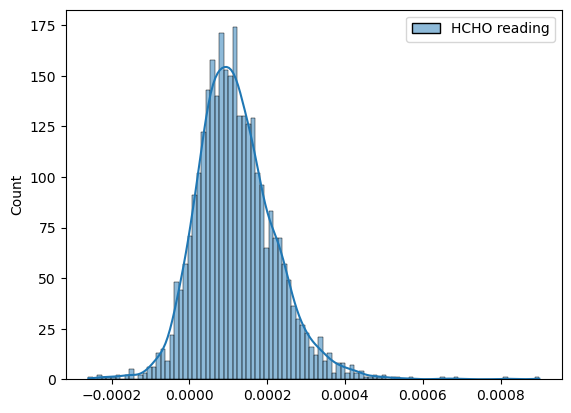

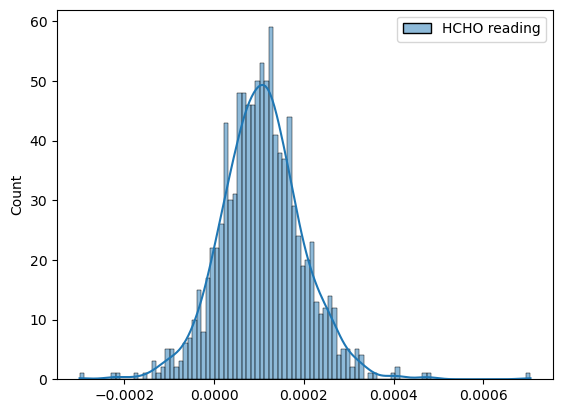

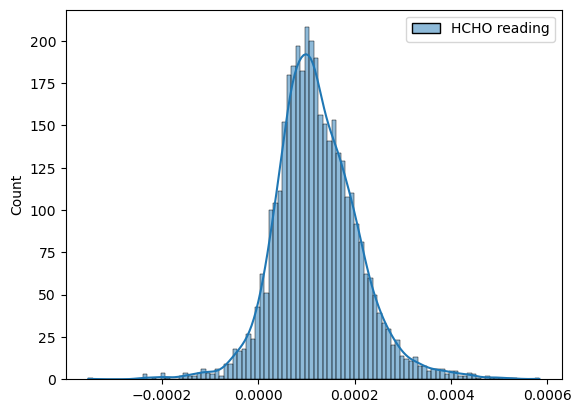

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

for dataset in [col_mat_nuw_datasset, mon_kur_jaf_dataset, kan_dataset]:
    # Convert PySpark DataFrame to Pandas DataFrame for plotting
    dataset_pd = dataset.toPandas()

    # Plot histograms for each numeric column
    sns.histplot(data=dataset_pd, bins=100, kde=True)
    plt.show()

Null value counts for each column:
   HCHO reading  Location  Current Date  Next Date
0          1652         0             0          0


Null value counts for each column:
   HCHO reading  Location  Current Date  Next Date
0          1652         0             0          0


Null value counts for each column:
   HCHO reading  Location  Current Date  Next Date
0           793         0             0          0
